<a href="https://colab.research.google.com/github/mbajdman/Data-Science-Portfolio/blob/main/Customer%20Churn/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sony Research - Customer Turnover Prediction

####**Objective**
Develop a predictive model to identify customers likely to churn and provide insights into the factors contributing to churn.

#####**Tasks:**

* **Exploratory Data Analysis and Insight Extraction:** Conduct a thorough analysis of the provided dataset to understand the underlying patterns and relationships between variables. Extract key insights that shed light on customer behavior and potential churn indicators. This includes examining data distributions, identifying correlations, and visualizing key features.

* **Dataset Splitting:** Divide the dataset into training and testing sets. Justify the chosen splitting strategy, considering factors such as dataset size and the need for a representative evaluation of the model's performance. Address any potential imbalances in the dataset and strategies to mitigate their impact on model training and evaluation.

* **Predictive Model Building:** Develop a predictive model to classify customers as churners or non-churners. Explain the rationale behind selecting the chosen algorithm, considering its strengths and suitability for the given problem. Discuss any assumptions made during model development and the potential limitations of the chosen approach.

* **Model Evaluation Metrics:** Define appropriate metrics to assess the performance of the predictive model. Consider metrics such as accuracy, precision, recall, F1-score, and AUC, and discuss their relevance in the context of customer churn prediction. Explain how these metrics will be used to compare different models and select the best-performing one.

* **Deployment Considerations:** Discuss potential challenges and issues associated with deploying the model into a production environment. Address concerns related to data drift, concept drift, model monitoring, and maintenance. Outline strategies to mitigate these risks and ensure the long-term reliability and effectiveness of the deployed model.

##Exploratory Analysis and Extract Insights

In [27]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score

from warnings import filterwarnings

# Ignore warnings
filterwarnings('ignore')

# set random seed to have reproducible results
# sklearn uses numpy random seed
np.random.seed(42)

In [28]:
from google.colab import drive
drive.mount('/content/drive')
# Load data
sony_customers = '/content/drive/MyDrive/Colab Notebooks/Sony Reserch - Customer Churn Prediction/sony_customers.csv'

df = pd.read_csv(sony_customers)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Check fundamentals - data types, null count, column names, etc.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

We have a clean DataFrame without any null. Let's see if every row is unique to one customer (with a phone number).

In [30]:
df["phone number"].nunique()

3333

Having confirmed the uniqueness of customer phone numbers, we'll proceed to examine other columns that might represent categorical features. Our objective is to construct a final dataset by merging these categorical features with numerical ones. Identifying numerical features is straightforward due to their continuous values. However, features like `area code` (provided their distinct values don't significantly increase the dataset's dimensionality) can be transformed using one-hot encoding to enhance insights for machine learning models. This step is crucial because leaving them in their original form could mislead the model, potentially implying an ordinal relationship between categories where none exists.

In [31]:
# drop phone number
df["area code"].nunique()

3

In [32]:
df["state"].nunique()

51

We will prefer to leave state values out of the dataset in order to not have issues with high dimensionality. We can start to process other categorical features.

Code transforms the `area code` column in the DataFrame `df`from categorical to numerical format.

In [33]:
area_code_dummies = pd.get_dummies(df["area code"]) # function for OHE
area_code_dummies = area_code_dummies.add_prefix('area_code_') # adds the prefix "area_code_" to avoid naming conflicts with other columns
area_code_dummies

,area_code_408,area_code_415,area_code_510
0,False,True,False
1,False,True,False
2,False,True,False
3,True,False,False
4,False,True,False
...,...,...,...
3328,False,True,False
3329,False,True,False
3330,False,False,True
3331,False,False,True


In [34]:
area_code_dummies

,area_code_408,area_code_415,area_code_510
0,False,True,False
1,False,True,False
2,False,True,False
3,True,False,False
4,False,True,False
...,...,...,...
3328,False,True,False
3329,False,True,False
3330,False,False,True
3331,False,False,True


In [35]:
# converts the voice mail plan column in df from categorical values ("yes" and "no") to numerical values (1 and 0)
df["voice mail plan"].loc[df["voice mail plan"] == "no"] = 0
df["voice mail plan"].loc[df["voice mail plan"] == "yes"] = 1
df["voice mail plan"] = df["voice mail plan"].astype("int64") # ensures the integers instead of strings
df["voice mail plan"]

,voice mail plan
0,1
1,1
2,0
3,0
4,0
...,...
3328,1
3329,0
3330,0
3331,0


In [36]:
df["international plan"].loc[df["international plan"] == "no"] = 0
df["international plan"].loc[df["international plan"] == "yes"] = 1
df["international plan"] = df["international plan"].astype("int64")
df["international plan"]

,international plan
0,0
1,0
2,0
3,1
4,1
...,...
3328,0
3329,0
3330,0
3331,1


We can form our final dataset by combining categorical features into numerical features.

In [37]:
df_final = df.drop(columns=["phone number", "state", "area code"])
df_final = pd.concat([df_final,area_code_dummies], axis=1)
df_final

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,area_code_408,area_code_415,area_code_510
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,91,11.01,10.0,3,2.70,1,False,False,True,False
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,103,11.45,13.7,3,3.70,1,False,False,True,False
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,104,7.32,12.2,5,3.29,0,False,False,True,False
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,89,8.86,6.6,7,1.78,2,False,True,False,False
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,121,8.41,10.1,3,2.73,3,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,26.55,215.5,126,18.32,...,83,12.56,9.9,6,2.67,2,False,False,True,False
3329,68,0,0,0,231.1,57,39.29,153.4,55,13.04,...,123,8.61,9.6,4,2.59,3,False,False,True,False
3330,28,0,0,0,180.8,109,30.74,288.8,58,24.55,...,91,8.64,14.1,6,3.81,2,False,False,False,True
3331,184,1,0,0,213.8,105,36.35,159.6,84,13.57,...,137,6.26,5.0,10,1.35,2,False,False,False,True


Okay, we created the final dataset. Now, will check the distribution of values to gain a deeper understanding of the dataset.

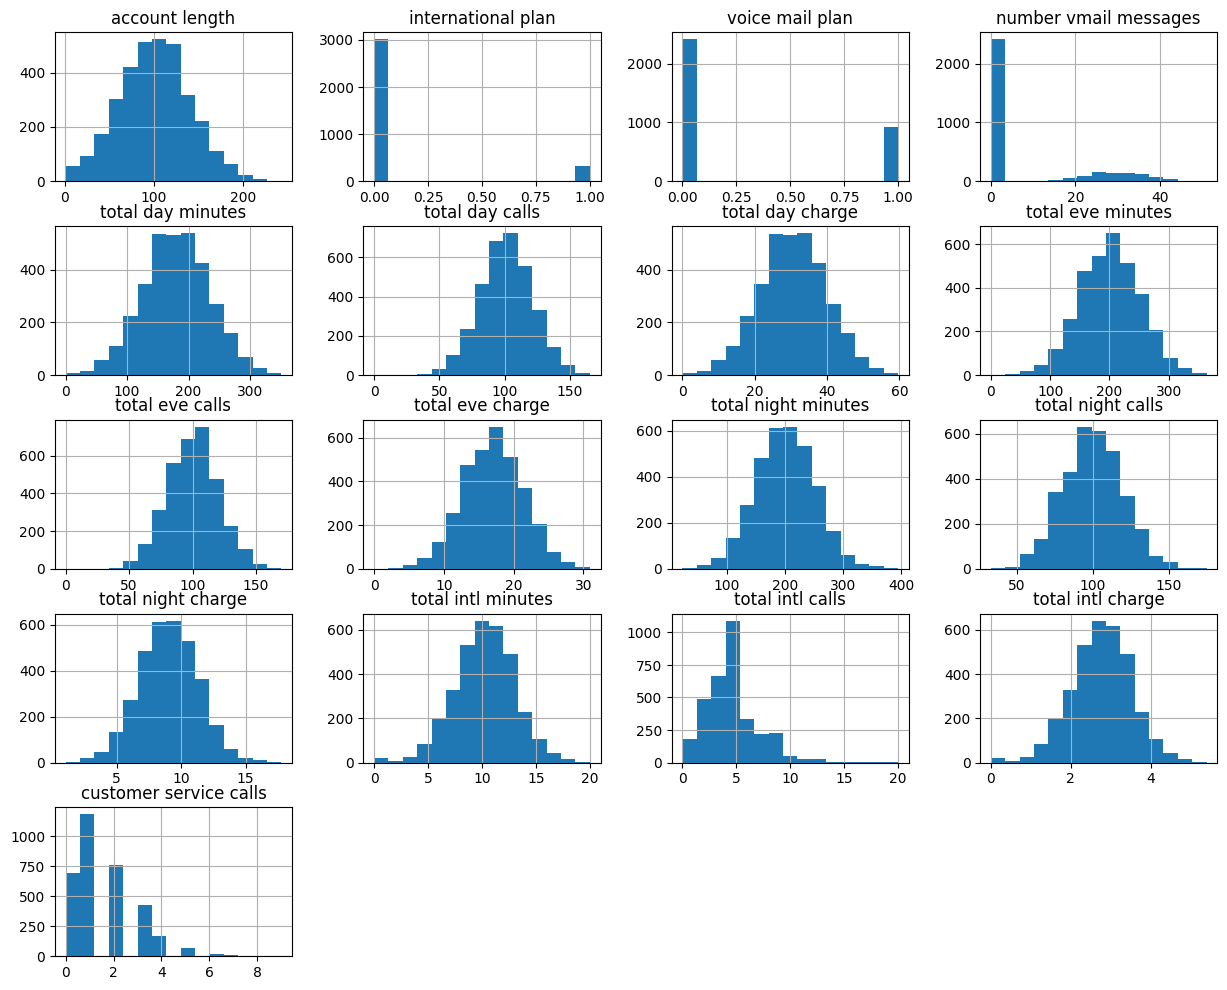

In [38]:
import matplotlib.pyplot as plt

df_final.hist(figsize=(15,12),bins = 15)
plt.show()

In [39]:
df_final.groupby(['churn'])['churn'].count()

,churn
churn,
False,2850
True,483


The distributions tell us:

* Most customers don't use voice mail service and international plans.
* Half of the customers live in area code 415.
* The company earns more by total day calls (check total day charge).
* We have an imbalanced dataset which could be tricky when choosing evaluation metrics.

Let's extract some insights into the relationship between features. First, observe the correlation.

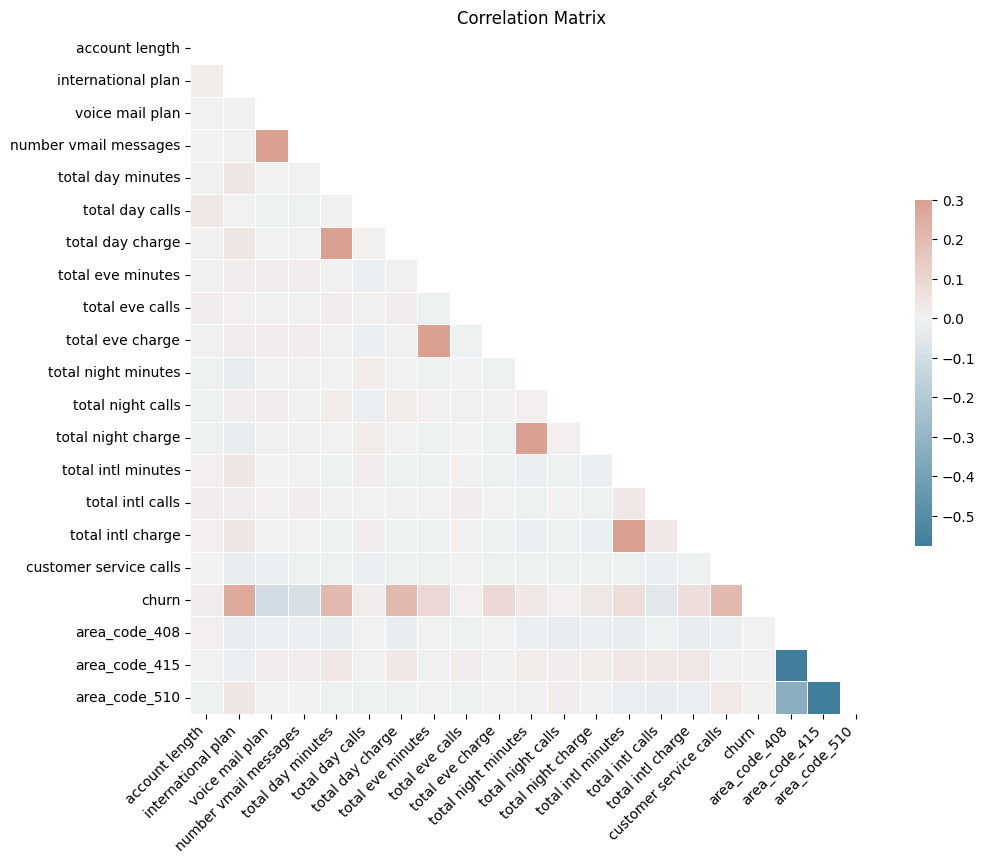

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# it could take some time to run this cell since we are calculating correlation matrix in a dimesion of (100x100)
# to have a better visualization, we will take only one triangle
# because other trangle is only its symmetry (i.e a x b and b x a)

# Generate a mask for the upper triangle
corr = df_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# Rotate x-ticks by 45 degrees
plt.xticks(rotation=45, ha='right')
plt.title("Correlation Matrix")
plt.show()


From the correlation matrix, we observe the following things:

* There is a positive correlation between:

  * total day charge, total day minutes, and churn
  * total eve minutes and total eve charge
  * total night minutes and total night charge
  * total intl minutes and total intl charge
  * total customer service calls and churn
  * number vmail messages and voice mail
  * international plan and churn
* There is a negative correlation between:

  * churn and voice mail plan
  * churn and number vmail messages
  * churn and total intl calls
  
Most of the relations are as expected. Still, there could be some interesting points such as the positive correlation between churn and international plan. It could be caused by the poor quality of international plans or calls. Let's check the individual effect of features on churn rate through a random forest classifier.

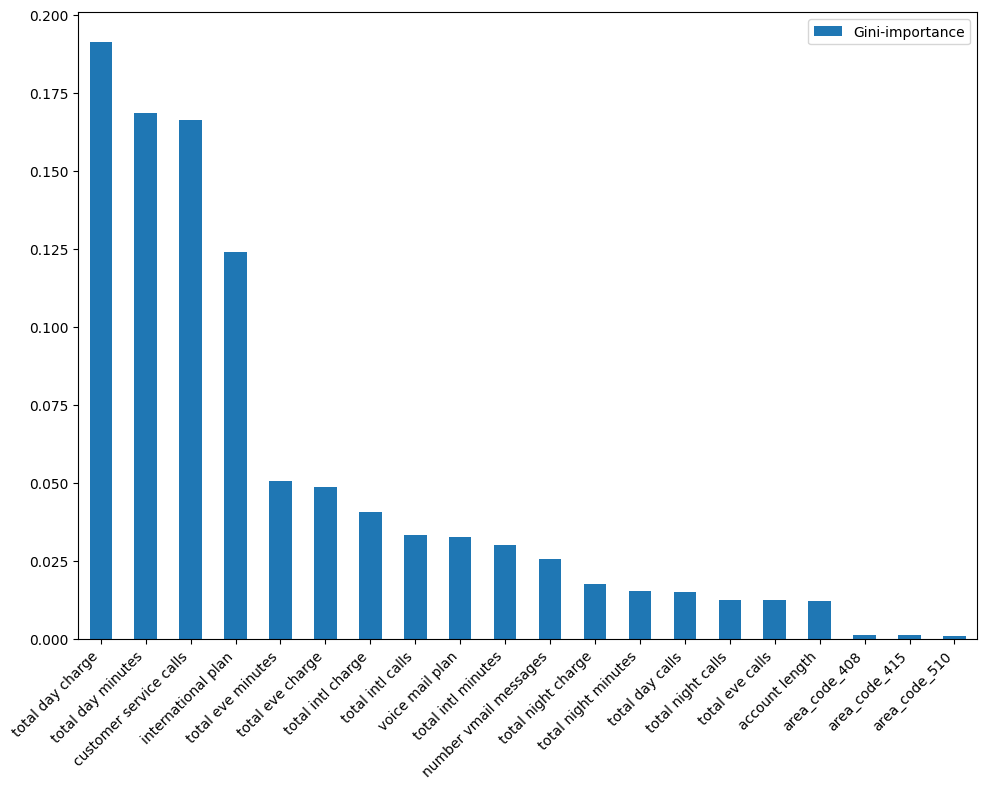

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Apply LabelEncoder for categorical target variable
le = LabelEncoder()
y = le.fit_transform(df_final["churn"])

# Drop the target column
X = df_final.drop(columns=["churn"])

# Scale the data
X = StandardScaler().fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
forest = RandomForestClassifier(max_depth=5)
forest.fit(X_train, y_train)

# Create a dictionary mapping feature names to their importances
feature_names = df_final.drop(columns=["churn"]).columns
feats = dict(zip(feature_names, forest.feature_importances_))

# Convert the dictionary into a DataFrame and sort by importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', figsize=(10,8))

# Rotate x-ticks by 45 degrees
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


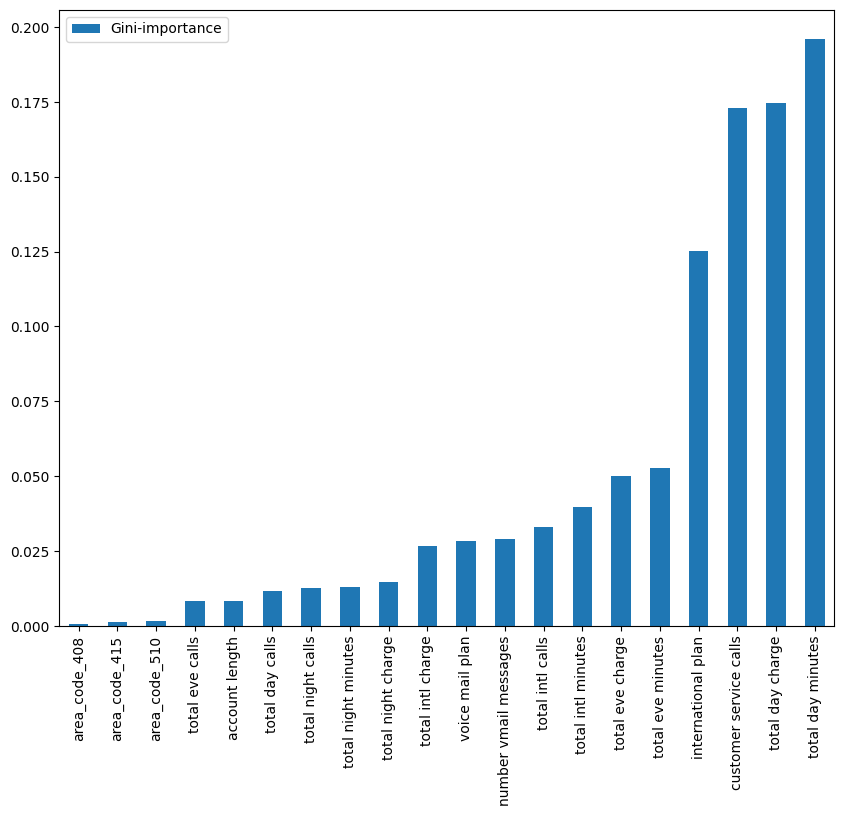

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

le = preprocessing.LabelEncoder()
# apply label encoder for churn since its values are also categories
y = le.fit_transform(df_final["churn"])

# drop label column
X = df_final.drop(columns=["churn"])

# train-test split
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# selected features are selected in multicollinearity check part
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest =  RandomForestClassifier(max_depth=5)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df_final.drop(columns=["churn"]).columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(10,8))
plt.show()

Gini-importance shows us which features would be most useful if we build a tree-based model with given features. According to analysis above, the most important three features over churn are: total day charge, total day minutes, and customer service calls.

##Train/Test Split
We will use an `80% - 20%` split since it is used as the most common ratio in applications (not including Deep Learning). Furthermore, we have an imbalanced dataset in terms of class distributions. We can use stratify option of `train_test_split( )` function of sklearn to split data to train and test datasets with the same distribution and be sure that samples of the test or train dataset are not only formed by the majority class.

In [43]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# apply label encoder for churn since its values are also categories
y = le.fit_transform(df_final["churn"])

In [44]:
X = df_final.drop(columns=["churn"])

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##Predictive Model
We will apply a bunch of classifiers and decide to pick one to use in production based on the performance. Hyperparameters of the given classifiers are chosen as trial-error without applying an advanced hyperparameter tuning mechanism.

In [46]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

random_seed = 25
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "XGBoost",
    "LightGBM"
]

classifiers = [

    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025), # C-controls the regularization strength to prevent overfitting, lower the value stronger regular.
    SVC(gamma=2, C=1), # gammna - controls influence of training data on decison boundry, higher value means points have more localized influence
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=random_seed ), # Radial Basis Function, defines how similarity between data points are measured
    DecisionTreeClassifier(max_depth=5, random_state=random_seed ),
    RandomForestClassifier(max_depth=5, random_state=random_seed ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=random_seed ),
    AdaBoostClassifier(random_state=random_seed ),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=0), #  multi-class log loss/cross-entropy, metric for multiclass class. problems
    LGBMClassifier(random_state=random_seed),
]

##Metrics
We have an imbalanced dataset, which means we need to be careful about our evaluations. Let's say we have a very skewed dataset with a distribution of 99% of labels 1 and 1% of them 0. Then, if your model always predicts 1, it will have 99% accuracy but still not a good model. F1 score balances the precision `(False Positive - Error Type I)` and `recall (False Negative - Error Type II)` so we can have a good metric even for imbalanced datasets. Hence, we will use accuracy and F1 scores while comparing the performance of different algorithms.

In [47]:
from sklearn.metrics import f1_score

##Model Results
###5.1. Classical Machine Learning Models

In [48]:
for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        acc_score = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        f_score = f1_score(y_test, y_pred, average='macro')
        print("accuracy:", "{:.3f}".format(acc_score), "f1_score:", "{:.3f}".format(f_score), "Model:", name)
        print()

accuracy: 0.873 f1_score: 0.667 Model: Nearest Neighbors

accuracy: 0.855 f1_score: 0.461 Model: Linear SVM

accuracy: 0.855 f1_score: 0.461 Model: RBF SVM

accuracy: 0.898 f1_score: 0.761 Model: Gaussian Process

accuracy: 0.918 f1_score: 0.823 Model: Decision Tree

accuracy: 0.901 f1_score: 0.733 Model: Random Forest

accuracy: 0.909 f1_score: 0.789 Model: Neural Net

accuracy: 0.864 f1_score: 0.656 Model: AdaBoost

accuracy: 0.849 f1_score: 0.699 Model: Naive Bayes

accuracy: 0.847 f1_score: 0.678 Model: QDA

accuracy: 0.943 f1_score: 0.876 Model: XGBoost

[LightGBM] [Info] Number of positive: 386, number of negative: 2280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 20
[LightGBM] [In

We obtained good accuracy and satisfying F1 score on tree-based methods. The best performed model is XGBoost with 0.94 accuracy and 0.88 F1-score. Let's visualize the Decision Tree and see how tree-based algorithms decide for our particular problem.

In [49]:
def plot_decision_tree(maximum_depth, criterion_type, split_type, X_train, y_train, X_test, y_test, feature_names):
    # Model
    clf = DecisionTreeClassifier(max_depth=maximum_depth, criterion=criterion_type, splitter=split_type)
    clf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    acc_score = clf.score(X_test, y_test)
    f_score = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {acc_score:.2f}, F1-score: {f_score:.2f}")

    # Plot decision tree
    graph = tree.export_graphviz(
        clf,
        out_file=None,
        rounded=True,
        proportion=False,
        feature_names=feature_names,
        precision=2,
        class_names=["Not churn", "Churn"],
        filled=True
    )

    pydot_graph = pydotplus.graph_from_dot_data(graph)
    pydot_graph.set_size('"10,10"')
    plt = Image(pydot_graph.create_png())
    display(plt)

# Example usage
# plot_decision_tree(3, "gini", "best", X_train, y_train, X_test, y_test, feature_names)

Accuracy: 0.89, F1 Score: 0.70


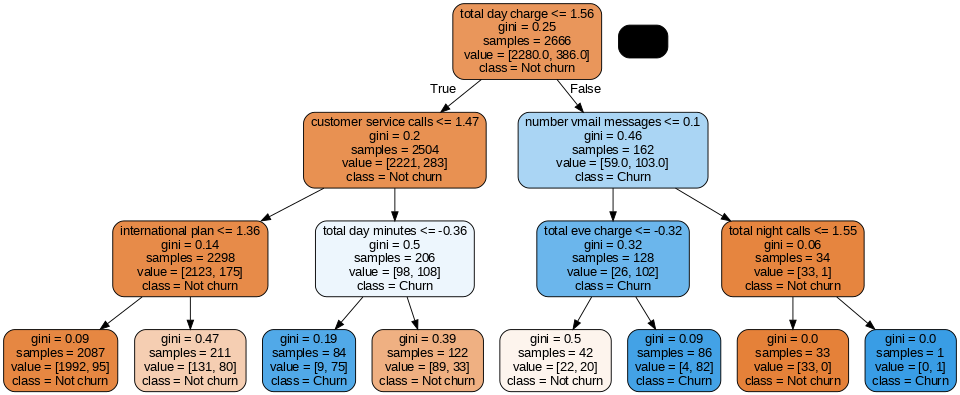

In [50]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import SVG, display, Image
import pydotplus
from sklearn.metrics import accuracy_score, f1_score

# Function attributes
# - maximum_depth: depth of tree
# - criterion_type: ["gini" or "entropy"]
# - split_type: ["best" or "random"]

def plot_decision_tree(X_train, y_train, X_test, y_test, df_final,
                       maximum_depth, criterion_type, split_type):
    """
    Plots a decision tree based on given parameters and evaluates its performance.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Testing features
    - y_test: Testing labels
    - df_final: Final DataFrame (used for feature names)
    - maximum_depth: Maximum depth of the tree
    - criterion_type: Criterion type for splitting ["gini" or "entropy"]
    - split_type: Split type ["best" or "random"]
    """

    # Model
    clf = DecisionTreeClassifier(max_depth=maximum_depth, criterion=criterion_type, splitter=split_type)
    clf.fit(X_train, y_train)

    # Evaluate model
    y_pred = clf.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred, average='macro')  # Using macro for multi-class
    print(f"Accuracy: {acc_score:.2f}, F1 Score: {f_score:.2f}")

    # Plot decision tree
    graph = tree.export_graphviz(clf, out_file=None,
                                 rounded=True, proportion=False,
                                 feature_names=df_final.drop(columns=["churn"]).columns.to_list(),
                                 precision=2,
                                 class_names=["Not churn", "Churn"],
                                 filled=True)

    pydot_graph = pydotplus.graph_from_dot_data(graph)
    pydot_graph.set_size('"10,10"')
    plt = Image(pydot_graph.create_png())
    display(plt)

# Example usage
plot_decision_tree(X_train, y_train, X_test, y_test, df_final, 3, "gini", "best")


accuracy: 0.94 f1_score: 0.87


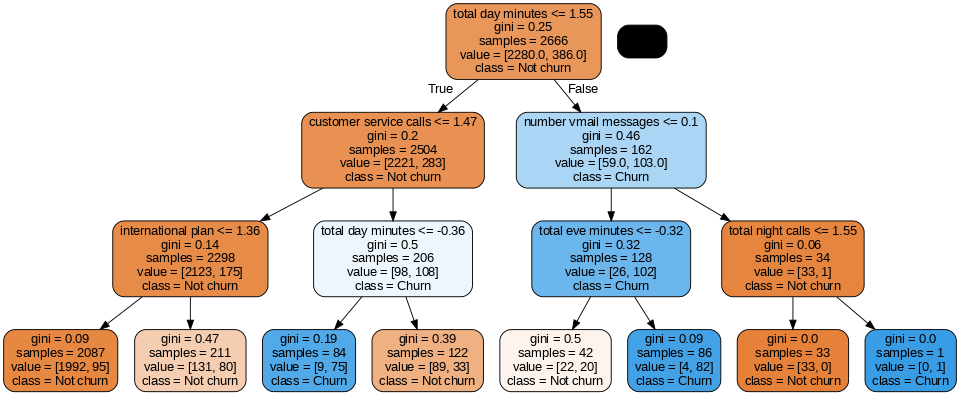

In [51]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import SVG,display, Image
import pydotplus # visualizing graphs fro decision tree

#Function attributes
#maximum_depth  - depth of tree
#criterion_type - ["gini" or "entropy"]
#split_type     - ["best" or "random"]

def plot_decision_tree(maximum_depth,criterion_type,split_type) :


    #model
    clf = DecisionTreeClassifier(max_depth=3)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("accuracy:", "{:.2f}".format(acc_score), "f1_score:", "{:.2f}".format(f_score))

    #plot decision tree
    graph = tree.export_graphviz(clf,out_file=None,
                                        rounded=True,proportion = False,
                                        feature_names = df_final.drop(columns=["churn"]).columns.to_list(),
                                        precision  = 2,
                                        class_names=["Not churn","Churn"],
                                        filled = True,

                  )

    pydot_graph = pydotplus.graph_from_dot_data(graph)
    pydot_graph.set_size('"10,10"')
    plt = Image(pydot_graph.create_png())
    display(plt)

plot_decision_tree(3,"gini","best")

This visualization shows us how the decision tree grows via splitting based on feature values. For example, left-hand side of the tree visualize customers who do not use international plan churns less than who have internal plan. Another example from level two of the tree is customers who call customers service less than 1.47 don't churn while others have higher probability to churn.

##Deep Learning Model
Let's explore the performance of an Artificial Neural Network (ANN) on this problem without extensive hyperparameter tuning, primarily for experimental purposes.

In [58]:
# Set seed for reproducibility
import tensorflow # Explicitly import tensorflow
tensorflow.random.set_seed(25)
from sklearn.metrics import confusion_matrix, f1_score # Ensure f1_score is imported

# Define the FNN model
def create_fnn_model(input_dim):
    """Creates a simple ANN model with two hidden layers."""
    classifier = Sequential()

    # Input layer and first hidden layer
    classifier.add(Dense(
        units=6,
        kernel_initializer='uniform',
        activation='relu',
        input_dim=input_dim
    ))

    # Second hidden layer
    classifier.add(Dense(
        units=6,
        kernel_initializer='uniform',
        activation='relu'
    ))

    # Output layer
    classifier.add(Dense(
        units=1,
        kernel_initializer='uniform',
        activation='sigmoid'
    ))

    return classifier

# Compile the model
def compile_model(model):
    """Compiles the ANN model with Adam optimizer and binary cross-entropy loss."""
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
def train_model(model, X_train, y_train):
    """Trains the ANN model on the training set."""
    model.fit(X_train, y_train, batch_size=10, epochs=100, verbose=0)

# Evaluate the model
def evaluate_model(model, X, y):
    """Evaluates the model on the given dataset."""
    loss, accuracy = model.evaluate(X, y, batch_size=10)
    return loss, accuracy

# Make predictions and evaluate
def make_predictions_and_evaluate(model, X_test, y_test):
    """Makes predictions on the test set and evaluates the model."""
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)

    loss, accuracy = evaluate_model(model, X_test, y_test)
    print('Test accuracy:', accuracy)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Calculate F1-score
    f1 = f1_score(y_test, y_pred)
    print('Test F1-score:', f1)

# Main execution
if __name__ == "__main__":
    # Create the model
    model = create_fnn_model(X.shape[1])

    # Compile the model
    compile_model(model)

    # Train the model
    train_model(model, X_train, y_train)

    # Evaluate on training set
    loss, accuracy = evaluate_model(model, X_train, y_train)
    print('Train accuracy:', accuracy)

    # Make predictions and evaluate on test set
    make_predictions_and_evaluate(model, X_test, y_test)

267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8767 - loss: 0.2977
Train accuracy: 0.8829707503318787
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8827 - loss: 0.2916
Test accuracy: 0.8590704798698425
[[546  24]
 [ 70  27]]
Test F1-score: 0.36486486486486486


In [60]:
# Set seed for reproducibility
import tensorflow # Explicitly import tensorflow
tensorflow.random.set_seed(25)
from sklearn.metrics import confusion_matrix, f1_score # Ensure f1_score is imported


classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

loss, accuracy = classifier.evaluate(X_train, y_train,
                            batch_size=10)

print('Train accuracy:', accuracy)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
loss, accuracy = classifier.evaluate(X_test, y_test,
                            batch_size=10)

print('Test accuracy:', accuracy)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

calculated_f1_score = f1_score(y_test, y_pred)
print('Test F1-score:', f1_score)

267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8698 - loss: 0.3020
Train accuracy: 0.8803451061248779
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
********************
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8827 - loss: 0.2890
Test accuracy: 0.8650674819946289
[[551  19]
 [ 71  26]]
Test F1-score: <function f1_score at 0x7f4d37f7ac00>


The performance of ANN couldn't beat the result of tree-based algorithms. In this case, we can continue with XGBoost as the algorithm will be in production due to it has combination of high accuracy and F1 score.


## Conclusion

Machine learning models like XGBoost, LightGBM, and ANN were evaluated for customer churn prediction.

**XGBoost showed the best performance**, achieving `0.94 accuracy` and a strong `0.88 F1-score` on the test set, outperforming LightGBM and the ANN. Decision tree analysis highlighted key churn drivers such as total day charge, total day minutes, and customer service calls.

The ANN model, with a test accuracy around `0.865` and an F1-score of about `0.366`, did not match the performance of tree-based methods, particularly in identifying churners (the minority class).

Considering the imbalanced dataset and the need for robust churn prediction, `XGBoost` is recommended for deployment due to its superior accuracy and F1-score.



###Deployment Issues
After the deployment of our ML model to production, we need to continue to monitor its performance since it could degrade over time due to internal or external reasons. It is recommended to update our models periodically, such as training with recent data to avoid common problems. There are two significant problems with the MLOps cycle:

* **Data drif**: Data drift is the situation where the model’s input distribution changes. It could be caused by broken data ingestion or serving pipeline, or a change in the nature of your problem. We can resolve this issue by fixing the broken data engineering pipelines where applicable or by training our model with more data including more recent data points if there is no deterioration in the data quality.

* **Concept drift**: Concept drift is the situation when the functional relationship between the model inputs and outputs changes. The context has changed, but the model doesn’t know about the change. Its learned patterns do not hold anymore. Hence, we need to learn a new model and even use another algorithm if our particular algorithm's performance is not good enough to use in production.